In [55]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv

In [56]:
rows = 10
df = pd.read_csv('./Data/Highway_V1.csv', nrows = rows)
print(df.head())
print(df.shape)
N = df.shape[0]



def write_csv(data_row):
    path  = "kernelABC_NO_vehsPerHour.csv"
    with open(path,'a+') as f:
        csv_write = csv.writer(f)
        csv_write.writerow(data_row)

write_csv(["maxSpeed","minGap","accel","decel", "θ distance", "Ɣ**2", "ƛ", "Σw"])

    maxSpeed    minGap     accel     decel       y_flow    y_speed   distance
0  25.000000  2.500000  2.600000  4.500000  1853.935338  12.747027   0.000000
1  21.474007  1.338518  4.533689  5.519486  1783.772727  21.129545  70.661578
2  15.154605  4.173119  7.197450  0.605079  1778.685455  14.513182  75.270607
3  24.810924  7.453838  9.010386  2.086053  1790.871818  24.017045  64.062632
4  40.728587  0.635601  6.904782  6.675052  1810.636364  38.569545  50.414320
(10, 7)


In [57]:
# Get measurement: Y
y_flow = np.array(df.loc[:,'y_flow']).reshape(N,1)
y_speed = np.array(df.loc[:,'y_speed']).reshape(N,1)
y = np.concatenate((y_flow, y_speed), axis=1)
print(y.shape)

# Get param: Theta
maxSpeed = np.array(df.loc[:,'maxSpeed']).reshape(N,1)
minGap = np.array(df.loc[:,'minGap']).reshape(N,1)
accel = np.array(df.loc[:,'accel']).reshape(N,1)
decel = np.array(df.loc[:,'decel']).reshape(N,1)
theta = np.concatenate((maxSpeed, minGap, accel, decel), axis=1)
print(theta.shape)
def cross_validation(lambda_, gamma): 
    distances =[]
    for i in range(N):
        y_star = y[i]
        y_c = y.copy()
        y_sensor = np.delete(y_c, i, axis=0)

        theta_star = theta[i]
        theta_c = theta.copy()
        theta_sensor = np.delete(theta_c, i, axis=0)
        
        kernelABC = kernel_ABC(lambda_ = lambda_, theta = theta_sensor, y = y_sensor, y_star = y_star, gamma = gamma)
        my_theta_hat = kernelABC.calc_theta_hat()
        distances.append(np.linalg.norm(theta_star - my_theta_hat))
    theta_distance = np.mean(distances)
    return theta_distance



(10, 2)
(10, 4)


In [58]:
'''
****************
Kernel ABC Class
****************

input: 
    - lambda: float
    - theta : 2D array of parameters
    - y     : 2D array of measures   (sensor data)
    - y_star: 1D array of measures   (ground truth)
    
output:
    - theta_hat: 1D array of parameters (predicted)
    - w        : calculated weight vector
'''

class kernel_ABC:
    def __init__(self, lambda_, theta, y, y_star,gamma):
        self.lambda_ = lambda_
        self.theta = theta
        self.y = y
        self.y_star = y_star
        
        self.N = len(y)
        self.GaMa = gamma
        self.G = self.calc_G()
        self.I = np.identity(self.N)
        self.k_vec = self.calc_k_vector()
    
    def get_N(self):
        return self.N
    
    def calc_k(self, yi, yj):
        __yi = yi.reshape(yi.shape[0],1)
        __yj = yj.reshape(yj.shape[0],1)
        norm_distance = np.linalg.norm(yi - yj) ** 2
        gramm_value = (yi-yj).T @ (yi-yj)
        __temp = (__yi - __yj).T @ (__yi - __yj)
        
        # checked with in multiple way of computation
        assert abs(norm_distance - __temp[0][0]) < 1, f'{norm_distance} {__temp}'
        assert abs(gramm_value - __temp[0][0]) < 1, f'{gramm_matrix} {__temp}'
        assert abs(norm_distance - gramm_value) < 1
        
        k = np.exp( - 1 * norm_distance / self.GaMa )
#         assert k > 0.0, f'k is non-positive value {k}, norm_distance {norm_distance}, GaMa {self.GaMa}'
        return k
        
    def calc_Gama(self):
        # check that input of Gamma computation is from y_simulator 
        GaMa_mat = []
        for i in range(self.N):
            GaMa_row = []
            for j in range(self.N):
                if j != i:
                    GaMa_row.append( (self.y[i] - self.y[j]).T @ (self.y[i] - self.y[j]) )
            GaMa_mat.append(GaMa_row)
        GaMa_mat = np.array(GaMa_mat)
        __Gama_original = np.median(GaMa_mat)
        
        # double check
        distance_matrix = []
        for i in range(self.N):
            one_row = []
            for j in range(self.N):
                if j != i:
                    __dis = np.linalg.norm(self.y[i] - self.y[j]) ** 2
                    one_row.append(__dis)
            else:
                distance_matrix.append(one_row)
        
        # end for loop
        Gama = np.median(distance_matrix)
        
        assert abs(Gama - __Gama_original) < 1
        print("Original Gama: ", __Gama_original)
        return __Gama_original

        Y_Ystar_norm2 = df.loc[:,'distance']**2
        median_Y_Ystar_norm2 = np.median(Y_Ystar_norm2)
        print("The median of the norm^2 distance: ", median_Y_Ystar_norm2)
#         return median_Y_Ystar_norm2
        
        Y_Ystar_norm2 = df.loc[:,'distance']**2
        mean_Y_Ystar_norm2 = np.mean(Y_Ystar_norm2)
        print("The mean of the norm^2 distance: ", mean_Y_Ystar_norm2)

#         return mean_Y_Ystar_norm2

    def calc_G(self):
        G = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N):
                G[i][j] = self.calc_k(self.y[i], self.y[j])
        return G
    
    def calc_k_vector(self):
        k_vec = []  # (99,1)
        for i in range(self.N):
            # checked input of k is from y_simulator and y_star
            out_kernel = self.calc_k( self.y[i], self.y_star )
            assert isinstance(out_kernel, float)
            k_vec.append( out_kernel )
        # k_vec = np.array(k_vec).reshape(-1,1) # list to array
#         print("k_vec shape: ", k_vec.shape)   # size - 99x1
        return k_vec
    
    def calc_w(self):
        assert self.G.shape == (self.N, self.N)
        assert self.I.shape == (self.N, self.N) 
        mat_before_inverse = self.G + self.N * self.lambda_ * self.I
        assert mat_before_inverse.shape == (self.N, self.N)
        w = np.linalg.inv(mat_before_inverse) @ self.k_vec
#         print("w shape: ", w.shape) # size - 99x1
        assert len(w) == self.N
        #print("weight sum: ", np.sum(w))
        return w
    
    def calc_theta_hat(self):
        self.w = self.calc_w()
        
        # double check to compute w
        check_params = []
        for one_param in self.theta.T:
            assert len(one_param) == self.N
            theta_hat_param = sum([self.w[index] * theta_value for index, theta_value in enumerate(one_param)])
            check_params.append(theta_hat_param)
        
        theta_hat = self.w.T @ self.theta
        return theta_hat

## Testing the Class ##
#lambda_param = 0.20
#gama = 1000000
#kernelABC = kernel_ABC(lambda_ = lambda_param, theta = theta_sensor, y = y_sensor, y_star = y_star, gama = gama)
#print("********************")
#my_theta_hat = kernelABC.calc_theta_hat()
#print("theta_hat: ", my_theta_hat)
#print("theta_star:", theta_star)


# Only uncomment if you want to summarize EVERYTHING into a single value
# WARNING: this gives close to no insight on the actual performance of your model!
#theta_distance = np.linalg.norm(theta_star - my_theta_hat)
# print("theta distance: ", theta_distance)

## Print to CSV ##
#result_row = [my_theta_hat[0], my_theta_hat[1], my_theta_hat[2], my_theta_hat[3], theta_distance, kernelABC.GaMa, lambda_param, np.sum(kernelABC.w)]
#write_csv(result_row)

In [59]:
y_star = y[0]
y_c = y.copy()
y_sensor = np.delete(y_c, 0, axis=0)

theta_star = theta[0]
theta_c = theta.copy()
theta_sensor = np.delete(theta_c, 0, axis=0)
        
kernelABC = kernel_ABC(lambda_ = 0.001, theta = theta_sensor, y = y_sensor, y_star = y_star, gamma = 1000000)
my_theta_hat = kernelABC.calc_theta_hat()

In [60]:
print(my_theta_hat)
print(theta_star)

[34.48221039  3.60824229  5.86979145  5.67932473]
[25.   2.5  2.6  4.5]


In [61]:
np.linalg.norm(theta_star - my_theta_hat)

10.159865047648378

In [62]:
lambda_ = [10**(-i) for i in range(1, 15)]
gamma = [10**i for i in range(1, 15)]
dist = np.zeros((len(lambda_),len(gamma)))
for l in range(len(lambda_)):
    for g in range(len(gamma)):
        dist[l][g] = cross_validation(lambda_[l], gamma[g])

In [63]:
print(dist)

[[  25.21374406   14.28344207    8.76390684    7.89749428    8.88136541
     9.03679696    9.0524708     9.05403911    9.05419595    9.05421164
     9.05421321    9.05421336    9.05421338    9.05421338]
 [  22.32538634   10.44470633    7.02496686    5.64444325    8.55303976
     9.08004156    9.14841034    9.15560369    9.15632701    9.15639939
     9.15640662    9.15640735    9.15640742    9.15640743]
 [  21.87235582   11.05829635    7.60797525    5.34644343    7.08044319
     8.73674001    9.1213363     9.1790789     9.18528152    9.18590657
     9.18596912    9.18597538    9.185976      9.18597606]
 [  21.82500311   13.2750933     9.15805991    7.03450911    6.10641812
     7.26197934    8.75577019    9.12569873    9.18237388    9.18847727
     9.18909247    9.18915404    9.1891602     9.18916081]
 [  21.82024792   13.95297615   11.08633982    9.90913131    7.49920377
     6.21282226    7.28056471    8.75767983    9.12613734    9.18270571
     9.18879917    9.18941339    9.18947486 

In [64]:
(l_min, g_min) = np.unravel_index(dist.argmin(), dist.shape)
lambda_optimal = lambda_[l_min]
gamma_optimal = gamma[g_min]
print(lambda_optimal, gamma_optimal)

0.001 10000


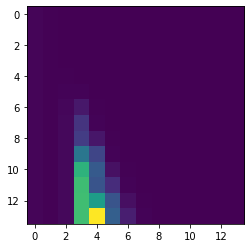

In [65]:
ax = plt.imshow(dist)

In [ ]:
lambda_ = [0.001*i for i in range(1, 100)]
gamma = [10000*i for i in range(1, 100)]
dist = np.zeros((len(lambda_),len(gamma)))
for l in range(len(lambda_)):
    for g in range(len(gamma)):
        dist[l][g] = cross_validation(lambda_[l], gamma[g])

In [ ]:
(l_min, g_min) = np.unravel_index(dist.argmin(), dist.shape)
lambda_optimal = lambda_[l_min]
gamma_optimal = gamma[g_min]
print(lambda_optimal, gamma_optimal)

In [ ]:
print(dist)

In [ ]:
ax = plt.imshow(dist)